<a href="https://colab.research.google.com/github/amutharun/GenAIWorkshop/blob/main/Talk2YourDoc%20RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [ ]:
!pip install pypdf==3.12.0 langchain==0.0.311 sentence-transformers==2.2.2 chromadb==0.3.26 openai==0.27.8 tiktoken==0.4.0

In [2]:
!pip install --upgrade python-dotenv

# Load env vars

In [3]:
# load env vars
from dotenv import load_dotenv
import os
import openai
load_dotenv()

# if directly using open ai api key
# openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.api_type = "openai"

# if we are using the azure open ai deployed model
openai.api_type = "azure"
openai.api_version = os.getenv("AZURE_API_VERSION"),
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT")  # Your Azure OpenAI resource's endpoint value.
openai.api_key = os.getenv("AZURE_OPENAI_API_KEY")

# Setup Models (embedding, GPTs)

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings

# Set the names of model. Use deployed model names if Azure Open AI. Else use direct model names if using open ai
embedding_model =  "EA-ADAembedding" # Deployment name of "text-embedding-ada-002"
gpt4turbo_model = "EAGPT4" # "gpt-4-turbo-preview"
chatgpt_model = "EAGPT35" # "gpt-3.5-turbo-1106"

openai_embeddings = OpenAIEmbeddings(deployment="EA-ADAembedding",
                              openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
                              openai_api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
                              openai_api_version=os.getenv("AZURE_API_VERSION"),
                              openai_api_type="azure")

gpt4_turbo_llm = AzureChatOpenAI(
        openai_api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
        openai_api_version=os.getenv("AZURE_API_VERSION"),
        deployment_name=gpt4turbo_model,
        openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        openai_api_type="azure",
        temperature=0.0
    )

chatgpt_llm = AzureChatOpenAI(
        openai_api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
        openai_api_version=os.getenv("AZURE_API_VERSION"),
        deployment_name=chatgpt_model,
        openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        openai_api_type="azure",
        temperature=0.0
    )

### Quick Check if the LLMs work

In [6]:
gpt4_turbo_llm.invoke("explain a computer in a sarcastic way in 1 line")

AIMessage(content="Oh, it's just a magical box that crashes whenever you need it the most.")

In [7]:
chatgpt_llm.invoke("explain NLP in a sarcastic way in 1 line")

AIMessage(content="Oh, NLP? It's just a fancy way for computers to pretend they understand human language, but we all know they're clueless.")

# Document Loading and Chunking

## Document Loading

In [18]:
from langchain.document_loaders import PyPDFLoader

In [12]:
PDF_PATH = "/content/Rich-Dad-Poor-Dad.pdf"

# create loader
loader = PyPDFLoader(PDF_PATH)
book = loader.load()

In [ ]:
book

## **Document Splitting**


**Can we use the whole book as is on ChatGPT?**
* When working with a whole book, copying and pasting it into chatGPT won't work due to the limitations of LLMs in processing large amounts of text at once.

**What is a context window?**
* LLMs have a context window, which is the span of text or tokens the model uses to generate or understand specific words or sequences within a sentence or text.
* The context window determines how much surrounding text the model considers for predictions or language processing.
* Due to the limitations of the context window, it is necessary to split the loaded PDF file into smaller sections referred to as "chunks" that can fit within the context window.

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunkByWord(text):
    return len(text.split(" "))

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, length_function = chunkByWord, chunk_overlap=30, add_start_index = False)
rec_chunks = text_splitter.split_documents(book)

## Let's understand Text Splitting using Text Splitter Playground

https://langchain-text-splitter.streamlit.app/

In [16]:
len(rec_chunks)

233

In [17]:
rec_chunks[1]

Document(page_content='“Rich Dad Poor Dad  is a starting point for anyone looking to  \ngain control of their financial future.”\n     – USA TODAY', metadata={'source': '/content/Rich-Dad-Poor-Dad.pdf', 'page': 1})

In [ ]:
rec_chunks[5]

Document(page_content='Best-selling Books \nby Robert T. Kiyosaki  \nRich Dad Poor Dad  \nWhat the Rich Teach Their Kids About Money –  \nThat the Poor and Middle Class Do Not\nRich Dad’s CASHFLOW Quadrant\nGuide to Financial Freedom\nRich Dad’s Guide to Investing\nWhat the Rich Invest in That the Poor and Middle Class Do Not\nRich Dad’s Rich Kid Smart Kid\nGive Your Child a Financial Head Start\nRich Dad’s Retire Young Retire Rich\nHow to Get Rich and Stay Rich\nRich Dad’s Prophecy\nWhy the Biggest Stock Market Crash in History Is Still Coming...\nAnd How You Can Prepare Yourself and Profit from It!\nRich Dad’s Success Stories\nReal-Life Success Stories from Real-Life People  \nWho Followed the Rich Dad Lessons\nRich Dad’s Guide to Becoming Rich  \nWithout Cutting Up Your Credit Cards  \nT urn Bad Debt into Good Debt\nRich Dad’s Who T ook My Money?\nWhy Slow Investors Lose and Fast Money Wins!  \nRich Dad Poor Dad for T eens\nThe Secrets About Money – That You Don’t Learn In School!  

# Embeddings and Vector Stores

In [19]:
from langchain.vectorstores import Chroma

In [20]:
# create vector store
vectordb = Chroma.from_documents(
    documents=rec_chunks,
    # embedding=embedding_func, # if you wanna try open source embeddings
    embedding = openai_embeddings,
    persist_directory=f"vector_db",
    collection_name="rich_dad_poor_dad")

# make vector store persistant
vectordb.persist()

### 4. Retrievers

Let's initialize a retriever which is an interface that returns documents given a query. It is more general than a vector store. A retriever does not store documents but only to returns (or retrieve) it. Vector stores can be used as the backbone of a retriever

In [27]:
retriver = vectordb.as_retriever(search_type="similarity", search_kwargs={"k": 3, "include_metadata": True})

In [28]:
from langchain.chains import ConversationalRetrievalChain

## Memory

In [38]:
from langchain.memory import ConversationBufferMemory

In [39]:
memory = ConversationBufferMemory(
    return_messages=True, memory_key="chat_history")

## Prompt Template

In [30]:
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema import (HumanMessage, SystemMessage)

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

In [32]:
template = """

- If the question is straightforward and can be answered concisely, respond briefly.
- If the question requires detailed explanation or reasoning, provide an in-depth response.
- Include the source file name from which the answer is retrieved. DO NOT PROVIDE the source if the provided context does not have the answer.
- Avoid using generic phrases like "Provide context" or "as per context."
- Respond solely based on the information provided; do not make assumptions.
- If a question falls outside the scope of the given information, politely inform the user.
- Strictly follow the instructions provided for answering questions.

{context}

Question: {question}
Use the following format to answer the question

Answer: <give accurate answer>
"""

In [33]:
system_template = "You are Chitti. You will call yourself as a Chitti. Chitti is a Generative AI powered buddy that will act as an insight engine to assist the humans with answers for questions related to the document."
system_message_prompt = SystemMessagePromptTemplate.from_template(system_template)

human_template = template
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template,input_variables=["context", "question"])

chat_prompt_template = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])

### 7. Chains

Lets define a chain as our last step which allow us to combine multiple components (all above defined) together to create a single, coherent application.

In [40]:
from langchain.chains import ConversationalRetrievalChain

from IPython.display import Markdown

chain = ConversationalRetrievalChain.from_llm(llm=gpt4_turbo_llm,
                                           combine_docs_chain_kwargs={"prompt": chat_prompt_template},
#                                            retriever=LOTR_and_Compress_Retriever,
                                          retriever=retriver,
                                           memory=memory,
                                           return_source_documents=True)

In [105]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm=gpt4_turbo_llm,
    chain_type='stuff',
    retriever=retriver,
    verbose=True,
    # return_source_documents=True,
    chain_type_kwargs={
        # "verbose": True,
        "prompt": chat_prompt_template
    }

)

In [135]:
def print_chain_results(chain,question):
  response = chain({"query": question})
  print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print(f"==> Query : {response['query']}")
  print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print(f"==> {response['result']}")
  print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print(f"==> Sources : ")
  try:
    for i in range(len(response['source_documents'])):
      print(response['source_documents'][i].metadata['source'] + "- pg:" +str(response['source_documents'][i].metadata['page']))
      print(response['source_documents'][i])
      print("-----------------------")
  except:
    pass


In [107]:
# question
question = "Who are you?"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : Who are you?
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer : Answer: I am Chitti, a Generative AI powered buddy designed to assist humans with answers for questions related to the document.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Sources : 


In [108]:
question = "Can I call you Stella?"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : Can I call you Stella?
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer : Answer: No, you cannot call me Stella. I am Chitti, your AI powered buddy.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Sources : 


In [110]:

qa_chain = RetrievalQA.from_chain_type(
    llm=gpt4_turbo_llm,
    chain_type='stuff',
    retriever=retriver,
    verbose=True,
    return_source_documents=True,
    chain_type_kwargs={
        # "verbose": True,
        "prompt": chat_prompt_template
    }

)

In [134]:
question = "How many years did the rich dad teach the author?"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : How many years did the rich dad teach the author?
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer: The rich dad taught the author for a period of 30 years.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Sources : 
page_content='Rich Dad Poor Dad7\nAnd that has made all the difference.\nOver the years, I have often reflected upon Robert Frost’s poem. \nChoosing not to listen to my highly educated dad’s advice and attitude \nabout money was a painful decision, but it was a decision t

In [130]:
question = "What is the lesson learnt from Robert Frost's poem?"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : What is the lesson learnt from Robert Frost's poem?
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer: The lesson learnt from Robert Frost's poem "The Road Not Taken" is about the importance of making your own choices and not being afraid to take the path less traveled. The speaker in the poem chooses the road that is less worn, symbolizing the choice of an unconventional path. This decision, as the poem concludes, has made all the difference in the speaker's life.
------------------------------------------------------------------------------------------------------------------------------------------------------

In [137]:
question = "What does the term Indian Giver mean?"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : What does the term Indian Giver mean?
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer: The term "Indian Giver" originated from a cultural misunderstanding between the first European settlers and some American Indians. If a settler was cold, the Indian would give the person a blanket. The settler, mistaking it for a gift, was often offended when the Indian asked for it back. The Indians also got upset when they realized the settlers did not want to give it back. Hence, the term "Indian giver" came into existence.
----------------------------------------------------------------------------------------------------

In [121]:
question = "What are the lessons on financial literacy?"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : What are the lessons on financial literacy?
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer : Answer: The lessons on financial literacy, also referred to as financial IQ, are made up of knowledge from four broad areas of expertise:

1. Accounting: This is financial literacy or the ability to read numbers. It's a vital skill for building an empire. Financial literacy is the ability to read and understand financial statements which allows you to identify the strengths and weaknesses of any business.

2. Investing: This is the science of “money making money.” It involves strategies and formulas.

3. Understanding 

In [122]:
gpt4_turbo_llm.invoke("give me some questions that I can ask on Rich Dad Poor Dad book")

AIMessage(content='1. What is the main message of "Rich Dad Poor Dad"?\n2. How does Robert Kiyosaki define wealth in the book?\n3. What are the key differences between the \'rich dad\' and the \'poor dad\'?\n4. How does Kiyosaki suggest one can achieve financial independence?\n5. What is the significance of financial education according to the book?\n6. How does the book challenge traditional views on employment and income?\n7. What are some practical financial tips that Kiyosaki offers in the book?\n8. How does Kiyosaki\'s view on real estate investment differ from conventional wisdom?\n9. What is the role of risk-taking in achieving financial success according to the book?\n10. How does the book address the concept of \'good debt\' and \'bad debt\'?\n11. What are the key lessons that Kiyosaki learned from his \'rich dad\'?\n12. How does the book suggest one can make money work for them, instead of working for money?\n13. How does Kiyosaki define assets and liabilities in the book?\n1

In [123]:
question = "How does Robert Kiyosaki define wealth in the book?"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : How does Robert Kiyosaki define wealth in the book?
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer : Answer: In the book, Robert Kiyosaki defines wealth as a person's ability to survive for a certain number of days forward. In other words, if a person stopped working today, how long could they survive? Wealth is measured by the cash flow from the asset column compared to the expense column. For example, if a person has a cash flow of $1,000 a month from their assets and monthly expenses of $2,000, they have enough cash flow for half a month. When the cash flow from assets equals or exceeds monthly expenses, a 

In [124]:
question = "What are the key differences between the rich dad and the poor dad"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : What are the key differences between the rich dad and the poor dad
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer : Answer: The key differences between the rich dad and the poor dad are primarily in their attitudes towards money and their thought processes. The poor dad often expressed negative thoughts about wealth, saying things like "I'll never be rich," and "Money doesn't matter." He believed in studying hard, earning a degree, and getting a good job to earn money. He also considered his home as his greatest investment. On the other hand, the rich dad always referred to himself as rich, even when he was br

In [138]:
question = "How does the book suggest one can make money work for them, instead of working for money?"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : How does the book suggest one can make money work for them, instead of working for money?
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer: The book suggests that one can make money work for them by awakening their financial genius. This involves changing one's thinking about money, understanding that money is only an idea, and learning the science of money making money. It encourages starting small, perhaps with a few dollars, and growing it into something big. The book emphasizes the importance of financial education and wisdom, suggesting activities such as reading books, attending seminars, and practicing. I

In [139]:
question = "How does the book critique the traditional education system\'s approach to financial literacy??"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : How does the book critique the traditional education system's approach to financial literacy??
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer: The book critiques the traditional education system's approach to financial literacy by highlighting that schools focus on scholastic and professional skills, but not on financial skills. It emphasizes that the subject of money is taught at home, not in school, and most people learn about money from their parents. The book suggests that this lack of financial education in schools is a contributing factor to why smart professionals like bankers, doctors, and accountants 

Source documents are quite long sometimes and they may not contain all relevant information.

## Contextual Compression Retriever


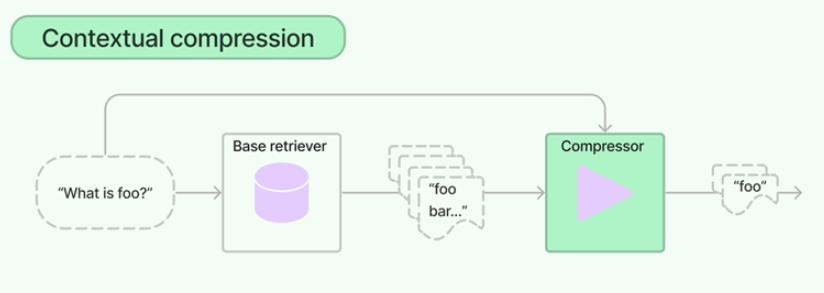

- The goal of contextual compression is to ensure that the compressed context retains the same meaning as the original documents while being more precise.
- Relevant documents can be compressed into two or three sentences using an LLM to extract the required information.
- The compressed information is then used to make a final call to the LLM for answering the question.
- By achieving effective compression, the cost of the final LLM call can be reduced. However, it requires multiple calls to the LLM initially for obtaining the compressed context.
- However, the drawback of this approach is the increased cost due to the multiple LLM calls needed for information compression.
- It is worth mentioning that the context compression process relies on utilizing an LLM.

In [118]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

In [119]:
compressor = LLMChainExtractor.from_llm(gpt4_turbo_llm)

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [143]:
compressed_docs = compression_retriever.get_relevant_documents("How does the book critique the traditional education system\'s approach to financial literacy??")
print_resp_and_source(compressed_docs)

==> Content 1: Without financial training, we all too often use the standard formulas to get through life: Work hard, save, borrow, and pay excessive taxes. Today, more than ever, we need better information. It requires using financial intelligence instead of hard work.
==> Source 1: {'source': '/content/Rich-Dad-Poor-Dad.pdf', 'page': 187}
--------------------------------------------------------------------------------------------------------
==> Content 2: "One of the reasons the rich get richer, the poor get poorer, and 
the middle class struggles in debt is that the subject of money is 
taught at home, not in school. Most of us learn about money from 
our parents. So what can poor parents tell their child about money? 
They simply say, “Stay in school and study hard.” The child may 
graduate with excellent grades, but with a poor person’s financial 
programming and mindset.
Sadly, money is not taught in schools. Schools focus on scholastic 
and professional skills, but not on finan

In [145]:
# changing retriver to compression_retriver

qa_chain = RetrievalQA.from_chain_type(
    llm=gpt4_turbo_llm,
    chain_type='stuff',
    retriever=compression_retriever,
    verbose=True,
    return_source_documents=True,
    chain_type_kwargs={
        "prompt": chat_prompt_template
    }
)

In [141]:
question = "How does the book critique the traditional education system\'s approach to financial literacy??"
print_chain_results(qa_chain,question)



> Entering new RetrievalQA chain...

> Finished chain.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Query : How does the book critique the traditional education system's approach to financial literacy??
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
==> Answer: The book critiques the traditional education system's approach to financial literacy by highlighting its lack of focus on financial skills. It points out that schools primarily concentrate on scholastic and professional skills, leaving students unprepared for real-world financial decisions. This lack of financial education is seen as a contributing factor to the ongoing struggle of the middle class with debt, the rich getting richer, and the poor getting poorer. The boo

### Supporting Functions to print responses beautifully

In [23]:
def print_resp_and_source(response):
  """Function to display the Source document and metadata"""
  for res in range(len(response)):
    print(f"==> Content {res+1}: {response[res].page_content}")
    print(f"==> Source {res+1}: {response[res].metadata}")
    print("--------------------------------------------------------------------------------------------------------")

In [24]:
def print_source_relevance_score(response):
  """Function to display the Source document and metadata"""
  for res in range(len(response)):
      print(f"==> Content {res+1}: {response[res][0].page_content}")
      print(f"==> Source {res+1}: {response[res][0].metadata}")
      print(f"==> Similarity Score :{round(response[res][1],2)} ")
      print("--------------------------------------------------------------------------------------------------------")